# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [17]:
import os

os.makedirs("module", exist_ok=True)

In [ ]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        ### train
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ############ 1 epoch 학습 종료 -> LR 를 변경 ###########
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")

        ####### 검증
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [19]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


## utils.py


In [20]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


## Import

In [21]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [23]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [24]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [25]:
class SmallModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(784, 16)
        self.lr2 = nn.Linear(16,10)
        self.relu = nn.ReLU()

    def forward(self, X) :
        out = nn.Flatten()(X) # (N, 1, 28, 28) -> (N, 1*28*28)
        out = self.relu(self.lr1(out))
        out = self.lr2(out)
        return out
    


In [26]:
summary(SmallModel(), (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 16]                 12,560
├─ReLU: 1-2                              [100, 16]                 --
├─Linear: 1-3                            [100, 10]                 170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
Total mult-adds (M): 1.27
Input size (MB): 0.31
Forward/backward pass size (MB): 0.02
Params size (MB): 0.05
Estimated Total Size (MB): 0.39

In [27]:
small_model = SmallModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [28]:
result = fit(train_loader, test_loader, small_model, loss_fn, optimizer, epochs, save_best_model=False, device=device, mode="multi")

KeyboardInterrupt: 

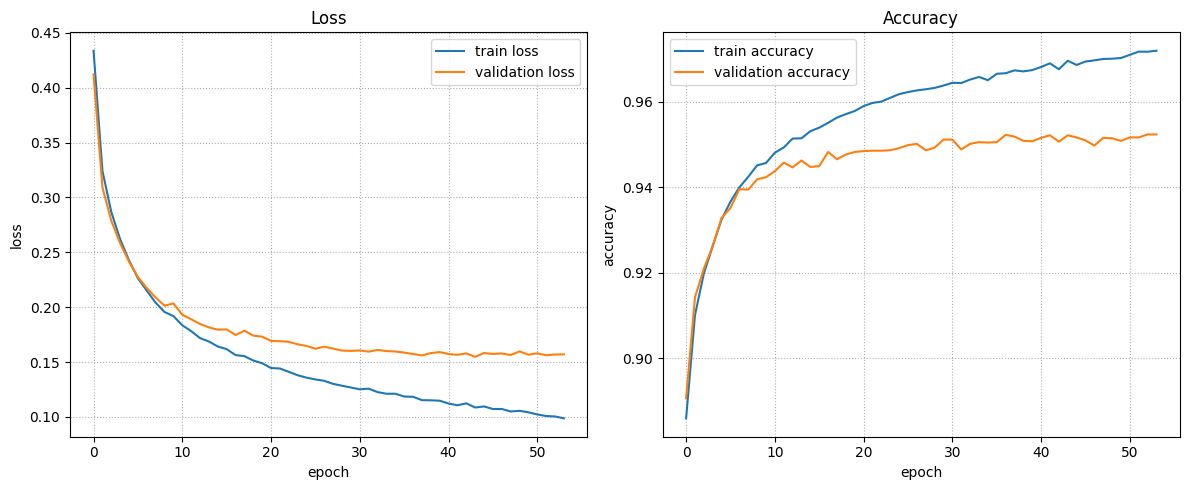

In [ ]:
plot_fit_result(result[0], result[1], result[2], result[3])

## 큰모델

In [38]:
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X) :
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)

        return out

In [35]:
b = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.ReLU())
b

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=2048, bias=True)
  (2): ReLU()
)

In [39]:
summary(BigModel(), (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-4                       [100, 1024]               2,098,176
│    └─ReLU: 2-5                         [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-6                       [100, 512]                524,800
│    └─ReLU: 2-7                         [100, 512]                --
├─Sequential: 1-4                        [100, 256]                --
│    └─Linear: 2-8                       [100, 256]               

In [41]:
Big_model = BigModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Big_model.parameters(), lr=lr)

In [42]:
result = fit(train_loader, test_loader, Big_model, loss_fn, optimizer, epochs, save_best_model=False, device=device, mode="multi")

Epoch[1/100] - Train loss: 0.14601 Train Accucracy: 0.95693 || Validation Loss: 0.15762 Validation Accuracy: 0.95180
Epoch[2/100] - Train loss: 0.07856 Train Accucracy: 0.97715 || Validation Loss: 0.10786 Validation Accuracy: 0.96840
Epoch[3/100] - Train loss: 0.06196 Train Accucracy: 0.98187 || Validation Loss: 0.10060 Validation Accuracy: 0.96880
Epoch[4/100] - Train loss: 0.04466 Train Accucracy: 0.98673 || Validation Loss: 0.09103 Validation Accuracy: 0.97560
Epoch[5/100] - Train loss: 0.04242 Train Accucracy: 0.98730 || Validation Loss: 0.09980 Validation Accuracy: 0.97130
Epoch[6/100] - Train loss: 0.02350 Train Accucracy: 0.99310 || Validation Loss: 0.07762 Validation Accuracy: 0.97920
Epoch[7/100] - Train loss: 0.02681 Train Accucracy: 0.99187 || Validation Loss: 0.09801 Validation Accuracy: 0.97560
Epoch[8/100] - Train loss: 0.01503 Train Accucracy: 0.99565 || Validation Loss: 0.08097 Validation Accuracy: 0.97950
Epoch[9/100] - Train loss: 0.02162 Train Accucracy: 0.99365 || V

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [43]:
#Dropout Layer 적용 : nn.Linear > nn.ReLU > nn.Dropout
class DropOutModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X) :
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)

        return out

In [44]:
summary(DropOutModel(), (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropOutModel                             [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─ReLU: 2-6                         [100, 1024]               --
│    └─Dropout: 2-7                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-8                       [100, 512]                524,800
│    └─ReLU: 2-9                         [100, 512]               

In [45]:
d_model = DropOutModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(), lr=lr)

result = fit(train_loader, test_loader, d_model, loss_fn, optimizer, epochs, save_best_model=False, device=device, mode="multi")

Epoch[1/100] - Train loss: 0.56660 Train Accucracy: 0.76285 || Validation Loss: 0.57378 Validation Accuracy: 0.76260
Epoch[2/100] - Train loss: 0.39159 Train Accucracy: 0.85480 || Validation Loss: 0.41602 Validation Accuracy: 0.85350
Epoch[3/100] - Train loss: 0.31733 Train Accucracy: 0.86870 || Validation Loss: 0.35328 Validation Accuracy: 0.86440
Epoch[4/100] - Train loss: 0.30508 Train Accucracy: 0.91217 || Validation Loss: 0.32693 Validation Accuracy: 0.91550
Epoch[5/100] - Train loss: 0.26919 Train Accucracy: 0.92578 || Validation Loss: 0.31383 Validation Accuracy: 0.92490
Epoch[6/100] - Train loss: 0.24218 Train Accucracy: 0.95958 || Validation Loss: 0.29230 Validation Accuracy: 0.95420
Epoch[7/100] - Train loss: 0.20980 Train Accucracy: 0.96402 || Validation Loss: 0.25842 Validation Accuracy: 0.95900
Epoch[8/100] - Train loss: 0.17847 Train Accucracy: 0.96558 || Validation Loss: 0.24852 Validation Accuracy: 0.95830
Epoch[9/100] - Train loss: 0.14041 Train Accucracy: 0.96978 || V

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [3]:
import torch
import torch.nn as nn
import torchinfo as summury



In [4]:

# BatchNormal Layer 적용 : nn.Linear > nn.BatchNorm1d > nn.ReLU > nn.Dropout

class BatchNormModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048),nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024),nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512),nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256),nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128),nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64),nn.BatchNorm1d(65), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32),nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X) :
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)

        return out

In [ ]:
summary(BatchNormModel)

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [2]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

In [7]:
lr = 0.001
model = BatchNormModel()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [8]:
# optimizer 의 현제 lr 조회
optimizer.param_groups[0]['lr']

0.001

#### StepLR


In [10]:
# 특정 에폭/스텝 마다 특정 비율로 lr 을 변경 (보통 줄여나간다.=> 그래야 보다 저 정확하게 값을 찾아내기 때문)
# 1. learningRate_Scheduler 객체 생성
step_lr_sceduler = torch.optim.lr_scheduler.StepLR(
    optimizer, # 학습률을 변경할 옵티마이저
    step_size= 30, # 몇 에폭 또는 스텝 당 lr 를 변경할 지 설정 lr_scheduler.step() -  지정한 횟수(30)만큼 호출하면 변경
    gamma=0.5 # 변경할 비율. 새 lr = 현재 lr * gamma
)

step_lr_sceduler.get_last_lr() # 오비마이저 현재 러닝레이트lr 조회

[0.001]

In [11]:
# 학습
lr_list = [] # 스케쥴러에게 lr 변경 요청 후 에폭/스텝 별 lr을 저장

epochs = 300
step_size = 10 #for x, y in dataloader : 의 반복횟수. 1 에폭 당 몇 번 학습할지
for epoch in range(epochs) :
    #1 에폭 학습
    for step in range(step_size) : #for x, y in dataloader :
        # 배치 만큼 학습 데이ㅌ를 가져와서 1스텝 학습
        #1 x, y 를 device로 이동
        #2 model 추론
        #3 loss 계산
        # prameter gradient 계산
        # 파라메터 업데이트
        optimizer.step()
        # 파라미터 의 그레디언트 초기화
        optimizer.zero_grad()
    #lr 스케쥴러를 이용해서 lr 을 변경 (스케쥴에 맞춰 변경)
    step_lr_sceduler.step() # 해당 스케쥴러의 위치(for문의 안인지 밖인지)로 에폭/스텝의 step 이 결정됨. # 현재는 1epoch = 한번
    lr_list.append(step_lr_sceduler.get_last_lr()[0]) 


c:\Users\USER\Documents\SKN21\07_deeplearning_pytorch\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\Documents\SKN21\07_deeplearning_pytorch\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\Documents\SKN21\07_deeplearning_pytorch\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\Documents\SKN21\07_deeplearning_pytorch\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\Documents\SKN21\07_deeplearning_pytorch\.venv\lib\site-packages\I

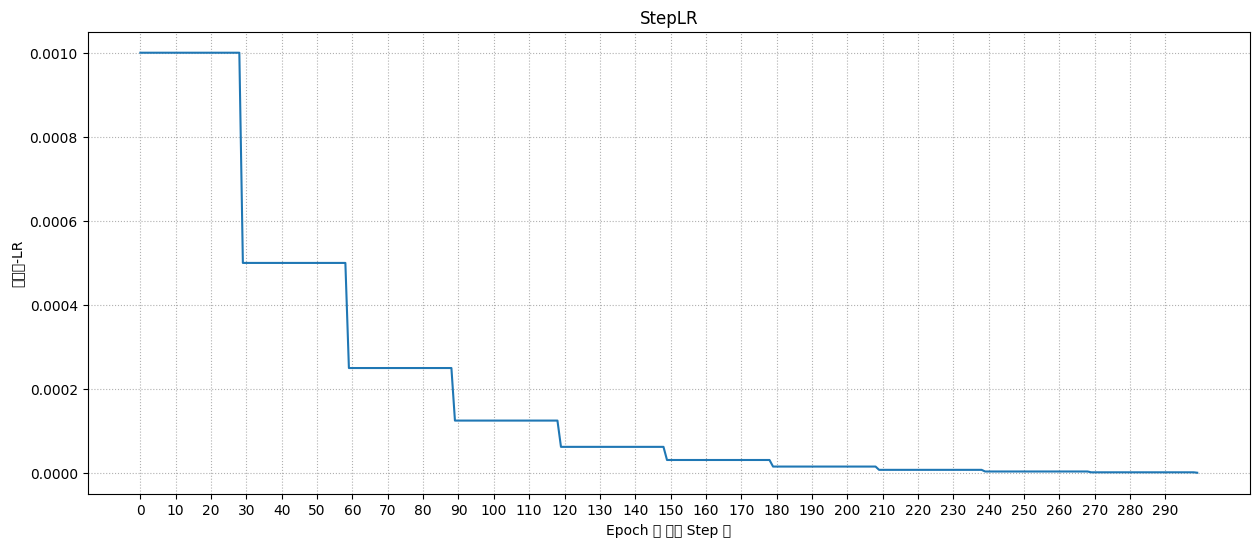

In [ ]:
# plt.rcParams['font.family'] = 'malgun gothic'
# plt.rcParams['axies']

plot_lr("StepLR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
ca_lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max = 20, # 변화주기 에폭/스텝(내려가는 주기, 올라가는 주기)
    eta_min=1e-6, # lr 최소값을 지정. 어디까지 내릴 지
)

# 초기 lr ~ eta_min 사이를 올라갔다 내려갔다 한다.


In [30]:
lr_list =[]

for epoch in range (epochs):
    for step in range(step_size):
        optimizer.step()
        optimizer.zero_grad()
    
    ca_lr_sch.step()
    lr_list.append(ca_lr_sch.get_last_lr()[0])

In [16]:
lr_list

[0.0009938503261272714,
 0.0009755527298894295,
 0.0009455577588320899,
 0.0009046039886902865,
 0.0008536998372026806,
 0.0007940987335200905,
 0.0007272682546199038,
 0.0006548539886902865,
 0.0005786390152875956,
 0.0005005000000000002,
 0.000422360984712405,
 0.00034614601130971394,
 0.0002737317453800965,
 0.00020690126647990978,
 0.00014730016279731957,
 9.639601130971382e-05,
 5.54422411679103e-05,
 2.5447270110570818e-05,
 7.149673872728741e-06,
 1e-06,
 7.149673872728684e-06,
 2.5447270110570706e-05,
 5.544224116791024e-05,
 9.639601130971376e-05,
 0.00014730016279731944,
 0.00020690126647990962,
 0.00027373174538009633,
 0.0003461460113097137,
 0.00042236098471240465,
 0.0005005,
 0.0005786390152875953,
 0.0006548539886902863,
 0.0007272682546199037,
 0.0007940987335200903,
 0.0008536998372026804,
 0.0009046039886902862,
 0.0009455577588320897,
 0.0009755527298894293,
 0.0009938503261272714,
 0.001,
 0.0009938503261272714,
 0.0009755527298894295,
 0.00094555775883209,
 0.0009

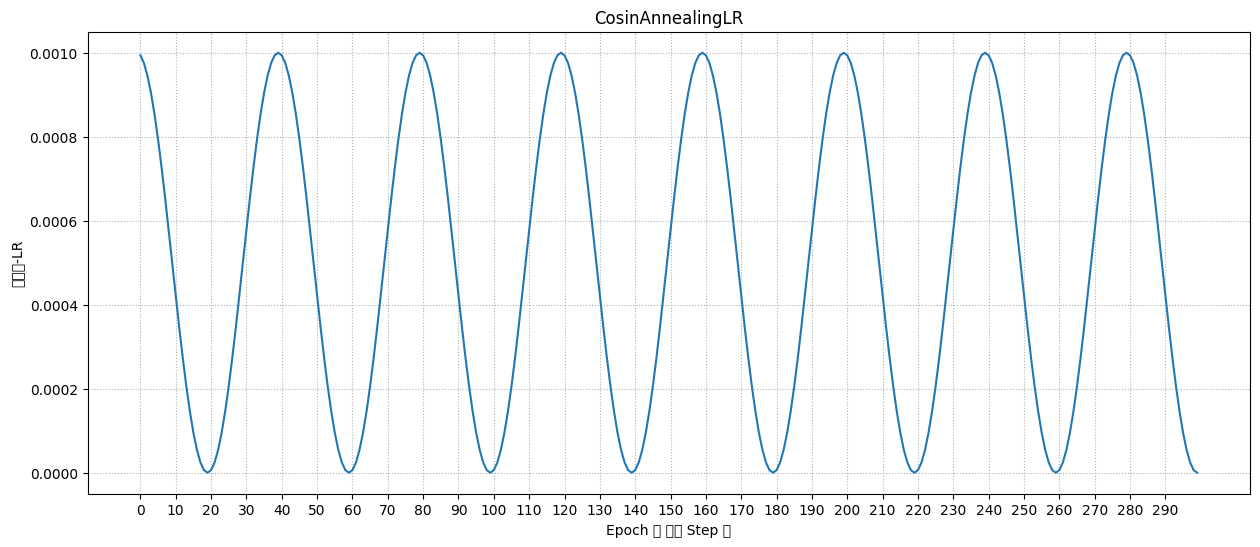

In [31]:
plot_lr("CosinAnnealingLR", lr_list) # ??? 왜 시작을 0에서 안 하지?

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
cawr_lr_sche = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0 =10, # 변화주기. (CosinAnnealingLR의 T_max)
    T_mult=2, # 새로운 변화주기 (새 변화주기 (T_0) = 현재 변화주기 (T-0)*T_mult)
    eta_min=1e-6
)

In [27]:
lr_list = []
for epoch in range(epoch):
    for step in range(step_size) :
        optimizer.step()
        optimizer.zero_grad()
    
    cawr_lr_sche.step()
    lr_list.append(cawr_lr_sche.get_last_lr()[0])

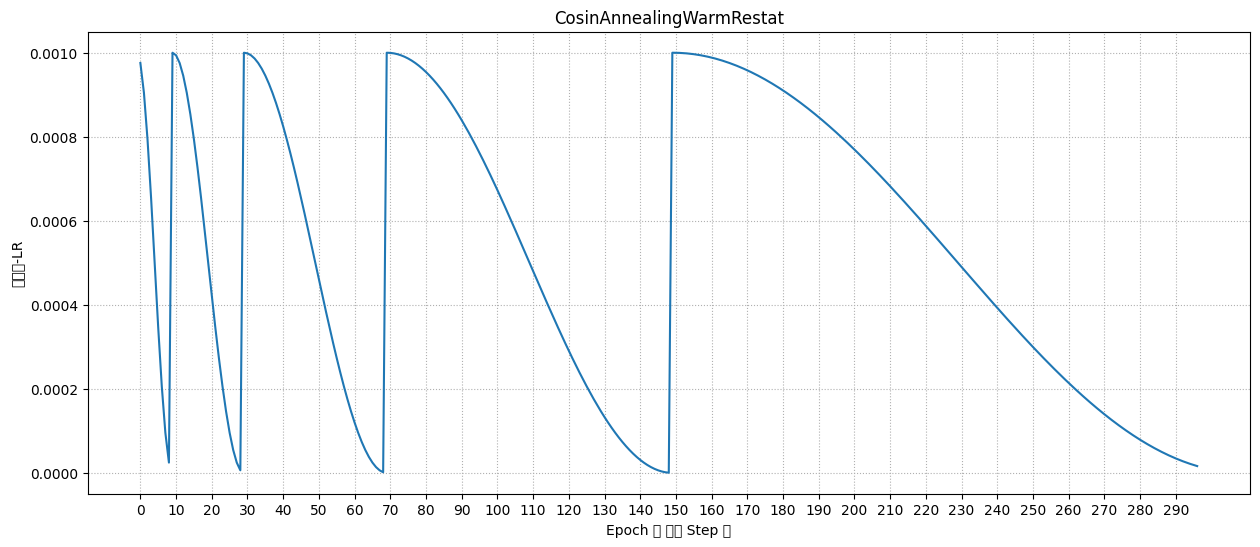

In [28]:
plot_lr("CosinAnnealingWarmRestat", lr_list)